# ***Set parameters***

In [37]:
__algo__ = "Agg"               #Name of the Clustering algorithm
__emb__ = "glove"                 #Name of the Word Embeddings used (glove, w2v, ftt), MUST set directory below
__sentemb__ = "pmeans5"           #Name of Sentence Embedding algorithm used
recnum = 3000                     #Number of records to be read from files
k = 100                            #Number of Clusters
usesqrt = False                   #Set value of k to sqrt of recnum, overrides k
randomsample = False              #Random Sampling to be True/False for records which are read
embedDir = "../MegaSentEmbs/"     #Directory where embeddings are saved for that selected embedding
modelDir = "../models/"           #Directory where models are saved
megadfDir = "../MegaDfs/"         #Directory Where Megadf is to be saved
plotDir = "../plots/"             #Directory where plots are saved
metadataDir = "../modelMetaData/" #Directory where performance and distribution params are to be stored
dumpDir = "../dump/"              #Directory where test outcomes are saved

# Actual Code

### imports and time

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import os, subprocess, sys
import datetime, time
import pickle

### File Settings

In [39]:
oldlist = os.listdir(embedDir)
filelist = sorted([embedDir+f for f in oldlist if f[-3:]=="pkl"])
filenum = len(filelist)
smalllist = filelist[:filenum]
print("Length of Smalllist: ", len(smalllist))

Length of Smalllist:  116


### Number of Records
It is Recommended to Set this at the top parameters

In [40]:
recnum = recnum

### Read all the pandas dataframes

In [41]:
%%time
megadf = pd.DataFrame()

if randomsample == True:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
    megadf = megadf.sample(recnum, random_state=42)
else:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
        if megadf.shape[0] >= recnum:
            megadf = megadf[:recnum]
            break

print("megadf.shape: ", megadf.shape)

randomsample:  False
megadf.shape:  (3000, 4)
CPU times: user 133 ms, sys: 12 ms, total: 145 ms
Wall time: 144 ms


In [42]:
predata = megadf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(3000, 250)


### Number of Clusters
It is Recommended to Set this at the top parameters

In [43]:
if usesqrt == True:
    print("usesqrt: ", usesqrt)
    sqrt_k = int(np.sqrt(data.shape[0]))
    k = int(sqrt_k)
else:
    print("usesqrt: ", usesqrt)
    k = k
print("k: ", k)

usesqrt:  False
k:  100


## Clustering
Please modify the functions here to change algorithm

In [44]:
%%time
print("Starting Clustering Process")
start_time = time.time()
model = cluster.AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
model.fit(data)
end_time = time.time()
timetrain = round(end_time-start_time, 2)
print("done! {}".format(timetrain))
print("k_means.fit(data) Done!")

Starting Clustering Process
done! 1.17
k_means.fit(data) Done!
CPU times: user 1.16 s, sys: 18.9 ms, total: 1.18 s
Wall time: 1.17 s


### Saving the output data into vars

In [45]:
# centroids = model.cluster_centers_
labels = model.labels_
megadf["clusterlabel"]=labels
# centroidDF = pd.DataFrame(centroids)


## Plotting

Text(0.5, 1.0, 'Agg with k=100 records=3000 features=250 using glove')

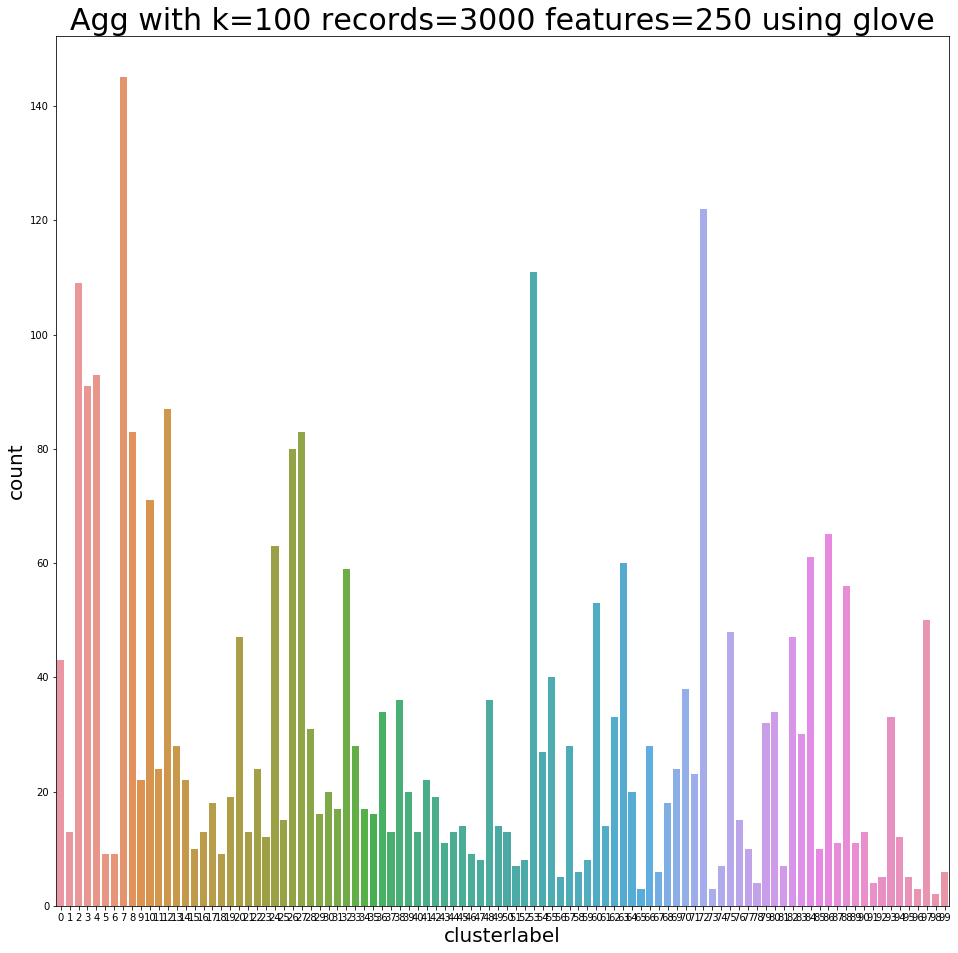

In [46]:
plt.figure(figsize=(16,16))
titlestring = "{} with k={} records={} features={} using {}".format(__algo__, k, data.shape[0], data.shape[1], __emb__)
snsplot = sns.countplot("clusterlabel", data=megadf)
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 30}
    )

### *Name given to saved files*

In [47]:
features = data.shape[1]
records = data.shape[0]
name = "{}_{}_{}_K{}_R{}_F{}".format(__algo__, __emb__, __sentemb__, k, records, features)
name

'Agg_glove_pmeans5_K100_R3000_F250'

### Saving Data

Save model

In [48]:
modelname = "{}_model.pkl".format(name)
pickle.dump(model, open(modelDir + modelname, 'wb'))

Save Plot

In [49]:
snspltname = "{}_plt.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

Save Megadf

In [50]:
clusterdfname = "{}_clustered_megadf.pkl".format(name)
megadf.to_pickle(megadfDir + clusterdfname)

Save Centroids

In [51]:
# centroidDF = pd.DataFrame(centroids)
# centroidDFname = "{}_centroids.pkl".format(name)
# centroidDF.to_pickle(megadfDir + centroidDFname)
# print(centroidDF.shape)

#### Open dataframe to test

In [52]:
sub = megadf.loc[:, ["id", "title", "abstract", "clusterlabel"]]
sub.tail()

,id,title,abstract,clusterlabel
2995,1588822,Defining the clinical role of the mammalian ta...,"[lung, cancer, biggest, cancer, killer, patien...",7
2996,1588823,Bio-functionalised nanoparticles for enzyme se...,"[inorganic, nanoparticles, accompanying, diver...",7
2997,1588824,Lithological mapping on the Antarctic Peninsul...,"[antarctic, peninsula, larger, uk, limited, ge...",26
2998,1588825,"WWOX, tumour suppressor and modifier gene, as ...","[wwox, tumour, suppressor, gene, demonstrated,...",7
2999,1588826,Improving efficiency in drive lines : an exper...,"[research, concern, improvement, power, effici...",53


In [53]:
megadf.columns

Index(['id', 'title', 'abstract', 'embedding', 'clusterlabel'], dtype='object')

# Performance Testing and Distribution


In [54]:
metadata = pd.DataFrame(columns=["Name", "Algo", "WordEmb", "SentEmb", "K", "R", "F", "SS", "CSavg", "CSmin", "CSmax", "T2Pavg", "T2LM", "T2LMP", "MEM"])

In [55]:
metadict = {
    "Name":None,                     #Name of the save file prefix
    "Algo":None,                     #Name of the Clustering algorithm
    "WordEmb":None,                  #Name of the Word Embeddings used (glove, w2v, ftt)
    "SentEmb":None,                  #Name of Sentence Embedding algorithm used 
    "K":None, "R":None, "F":None,    #Number of clusters, records and fetures
    "T2T":None,                      #Time required to train model
    "SS":None,                       #Silhoutte Score
    "DBS":None,                      #Davis Bouldin Score
    "CSavg":None,                    #Average Cluster Size
    "CSmin":None,                    #Minimum Cluster Size
    "CSmax":None,                    #Maximum Cluster Size
    "T2Pavg":None,                   #Average Time To Predict cluster of one record
    "T2LM":None,                     #Average Time to Load Model
    "T2LMP":None,                    #Amortized time to Predict after loading the model
    "MEM":None                      #Memory used by the Model
    }
metadict

{'Name': None,
 'Algo': None,
 'WordEmb': None,
 'SentEmb': None,
 'K': None,
 'R': None,
 'F': None,
 'T2T': None,
 'SS': None,
 'DBS': None,
 'CSavg': None,
 'CSmin': None,
 'CSmax': None,
 'T2Pavg': None,
 'T2LM': None,
 'T2LMP': None,
 'MEM': None}

In [56]:
metadict["Name"]=name
metadict["Algo"]=__algo__
metadict["WordEmb"]=__emb__
metadict["SentEmb"]=__sentemb__
metadict["K"]=k
metadict["R"]=recnum
metadict["F"]=features
metadict

{'Name': 'Agg_glove_pmeans5_K100_R3000_F250',
 'Algo': 'Agg',
 'WordEmb': 'glove',
 'SentEmb': 'pmeans5',
 'K': 100,
 'R': 3000,
 'F': 250,
 'T2T': None,
 'SS': None,
 'DBS': None,
 'CSavg': None,
 'CSmin': None,
 'CSmax': None,
 'T2Pavg': None,
 'T2LM': None,
 'T2LMP': None,
 'MEM': None}

#### Time to train

In [57]:
metadict["T2T"]=timetrain

#### Scores

In [58]:
ss = silhouette_score(data, labels, metric = 'euclidean')
dbs = davies_bouldin_score(data, labels)
metadict["SS"]=ss
metadict["DBS"]=dbs

#### Cluster Size

In [59]:
clusterdata = megadf.groupby("clusterlabel", as_index=True).size().reset_index(name="count")
clusterdata.head()

,clusterlabel,count
0,0,43
1,1,13
2,2,109
3,3,91
4,4,93


In [60]:
clusterdfname = "{}_clustered_counts.pkl".format(name)
clusterdata.to_pickle(megadfDir + clusterdfname)

In [61]:
countdata = clusterdata.groupby("count").size().reset_index(name="clusters")
display(countdata.head(3))
display(countdata.tail(3))

,count,clusters
0,2,1
1,3,3
2,4,2


,count,clusters
50,111,1
51,122,1
52,145,1


In [62]:
metadict["CSmax"] = max(clusterdata["count"])
metadict["CSmin"] = min(clusterdata["count"])
metadict["CSavg"] = np.mean(clusterdata["count"])

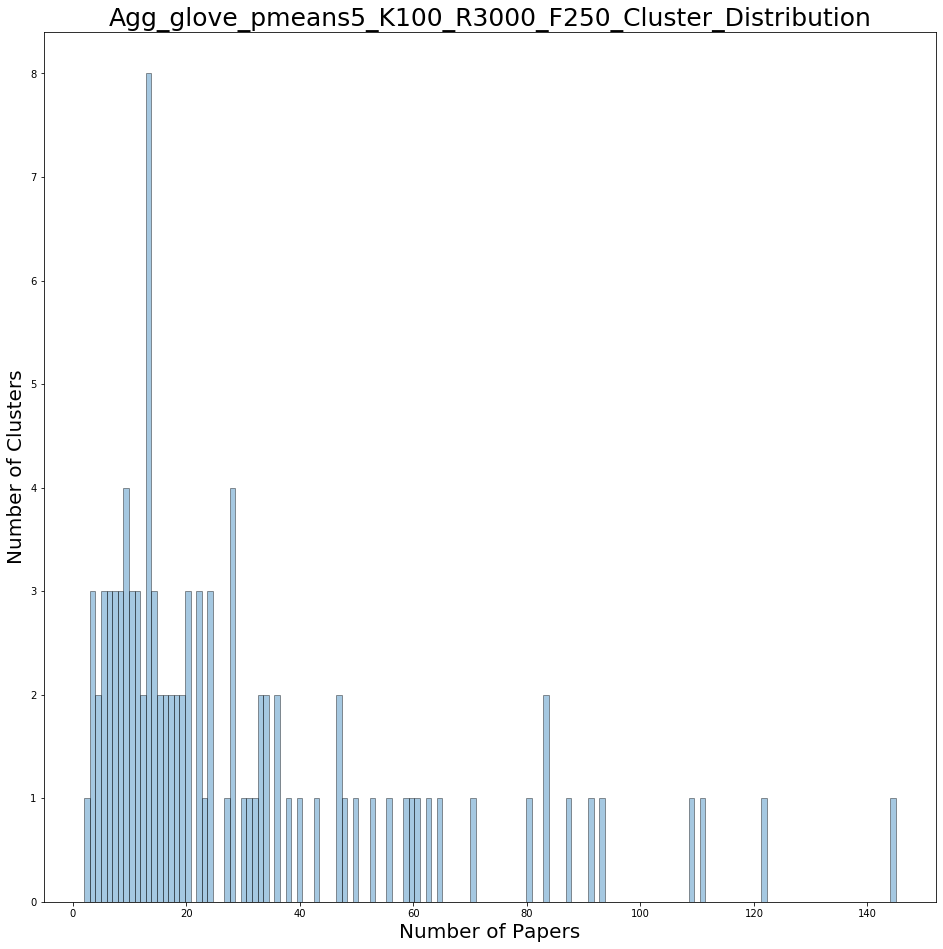

In [63]:
%matplotlib inline
plt.figure(figsize=(16,16))

sns.axes_style("whitegrid", {"axes.grid":True, 
                            'axes.spines.left': False,
                             'axes.spines.bottom': False,
                             'axes.spines.right': False,
                             'axes.spines.top': False})


titlestring = "{}_Cluster_Distribution".format(name)
snsplot = sns.distplot(clusterdata["count"], kde=False, bins=max(clusterdata["count"]),
                      hist_kws={'edgecolor':'black'},)
snsplot.set(xlabel="Number of Papers", ylabel="Number of Clusters")
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 25}
    )
plt.show()



In [64]:
snspltname = "{}_Cluster_Distribution.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

#### Prediction Time Performance

In [65]:
testdf = pd.DataFrame()
if recnum < 2000:
    samplenum = int(recnum / 10)
else:
    samplenum = 2000

for f in smalllist:
    tempdf = pd.read_pickle(f)
    testdf = megadf.append(tempdf, ignore_index = True, sort = False)
testdf = testdf.sample(samplenum, random_state=int(time.time()%100000))
predata = testdf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(2000, 250)


In [66]:
# print("Starting Predicting Performance")
# testmodel = model
# start_time = time.time()
# for d in data:
#     lb = testmodel.predict(d)
# end_time = time.time()
# timetest = end_time-start_time
# avgtime = timetest/data.shape[0]
# print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
avgtime = timetrain
metadict["T2Pavg"]=avgtime

In [67]:
print("Starting Loading Performance")
loadruns = 50
start_time = time.time()
for i in range(loadruns):
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/loadruns
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LM"] = avgtime
avgtime

Starting Loading Performance
Avgtime: 8.087635040283204e-05 Totaltime: 0.0040438175201416016


8.087635040283204e-05

In [68]:
# print("Starting Amortized Performance")
# loadruns = 5
# avglist = []

# for i in range(loadruns):
#     start_time = time.time()
#     testmodel = pickle.load(open(modelDir + modelname, 'rb'))
#     for d in data:
#         lb = testmodel.predict(d)
#     end_time = time.time()
#     timetest = (end_time-start_time)/data.shape[0]
#     avglist.append(timetest)

# timetest = np.sum(avglist)
# avgtime = np.mean(avglist)
# print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
avgtime = timetrain
metadict["T2LMP"] = avgtime
avgtime

1.17

In [69]:
modelsize = sys.getsizeof(pickle.dumps(model))
print("modelsize:", modelsize, "bytes")
metadict["MEM"]=modelsize

modelsize: 72627 bytes


In [70]:
metadict

{'Name': 'Agg_glove_pmeans5_K100_R3000_F250',
 'Algo': 'Agg',
 'WordEmb': 'glove',
 'SentEmb': 'pmeans5',
 'K': 100,
 'R': 3000,
 'F': 250,
 'T2T': 1.17,
 'SS': 0.045892341075522314,
 'DBS': 2.7545035482949736,
 'CSavg': 30.0,
 'CSmin': 2,
 'CSmax': 145,
 'T2Pavg': 1.17,
 'T2LM': 8.087635040283204e-05,
 'T2LMP': 1.17,
 'MEM': 72627}

In [71]:
metadata = metadata.append(metadict, ignore_index=True)
metadata

,Name,Algo,WordEmb,SentEmb,K,R,F,SS,CSavg,CSmin,CSmax,T2Pavg,T2LM,T2LMP,MEM,DBS,T2T
0,Agg_glove_pmeans5_K100_R3000_F250,Agg,glove,pmeans5,100,3000,250,0.045892,30.0,2,145,1.17,0.000081,1.17,72627,2.754504,1.17


In [72]:
metadataname = "{}_metadata.pkl".format(name)
metadata.to_pickle(metadataDir + metadataname)